# 🏏 IPL Data Excellence: Quality, Understanding & Profiling

## 1.1 Dataset Overview

### The Context
The **Indian Premier League (IPL)** is a professional Twenty20 cricket league in India. It is one of the most-watched and lucrative sporting events globally. 

We are analyzing a comprehensive dataset covering IPL seasons from **2008 to 2020**. This data exists in two primary layers:
1.  **Match Level**: High-level telemetry of individual games (venues, teams, toss decisions, winners).
2.  **Ball-by-Ball Level**: Granular execution data for every single delivery bowled in IPL history.

Analysis of this data is valuable for strategic team planning, win-probability modeling, and understanding the evolving physics of the T20 format.

In [33]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import missingno as msno
from scipy import stats

# Add src to path
sys.path.append(os.path.abspath('../'))

from src.data_loader import load_config, load_data

# Configuration
config = load_config('../config.yaml')
FIGURE_PATH = config.get('paths', {}).get('reports', '../reports/figures/')
os.makedirs(FIGURE_PATH, exist_ok=True)

sns.set_palette("viridis")
sns.set_style("whitegrid")

In [34]:
# Load Datasets
match_df = pd.read_csv('../data/raw/IPL Matches 2008-2020.csv')
ball_df = pd.read_csv('../data/raw/IPL Ball-by-Ball 2008-2020.csv')

print(f"Match Dataset Shape: {match_df.shape}")
print(f"Ball-by-Ball Dataset Shape: {ball_df.shape}")

Match Dataset Shape: (816, 20)
Ball-by-Ball Dataset Shape: (193617, 17)


In [35]:
# Memory Usage and Dtypes
print("--- Match Data Info ---")
match_df.info()
print("\n--- Ball Data Info ---")
ball_df.info()

--- Match Data Info ---
<class 'pandas.DataFrame'>
RangeIndex: 816 entries, 0 to 815
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               816 non-null    int64  
 1   season           816 non-null    str    
 2   city             765 non-null    str    
 3   date             816 non-null    str    
 4   match_type       816 non-null    str    
 5   player_of_match  812 non-null    str    
 6   venue            816 non-null    str    
 7   team1            816 non-null    str    
 8   team2            816 non-null    str    
 9   toss_winner      816 non-null    str    
 10  toss_decision    816 non-null    str    
 11  winner           812 non-null    str    
 12  result           816 non-null    str    
 13  result_margin    799 non-null    float64
 14  target_runs      814 non-null    float64
 15  target_overs     814 non-null    float64
 16  super_over       816 non-null    str    
 17  met

### Column Explanation

| Column | Type | Description |
| :--- | :--- | :--- |
| `id` / `match_id` | Key | Unique identifier for the match. |
| `city` | Categorical | The city where the match was played. |
| `team1`, `team2` | Categorical | The participating IPL franchises. |
| `toss_winner` | Categorical | The team that won the coin toss. |
| `toss_decision` | Categorical | Decision to 'bat' or 'field' first. |
| `winner` | Categorical | The franchise that won the match. |
| `over`, `ball` | Numeric | The chronological position in the inning. |
| `total_runs` | Numeric | Sum of batsman runs and extra runs (wides, no-balls). |

## 1.2 Missing Value Analysis

Data quality is the foundation of trustworthy modeling. We start by visualizing the density of missing information.

<Figure size 1000x400 with 0 Axes>

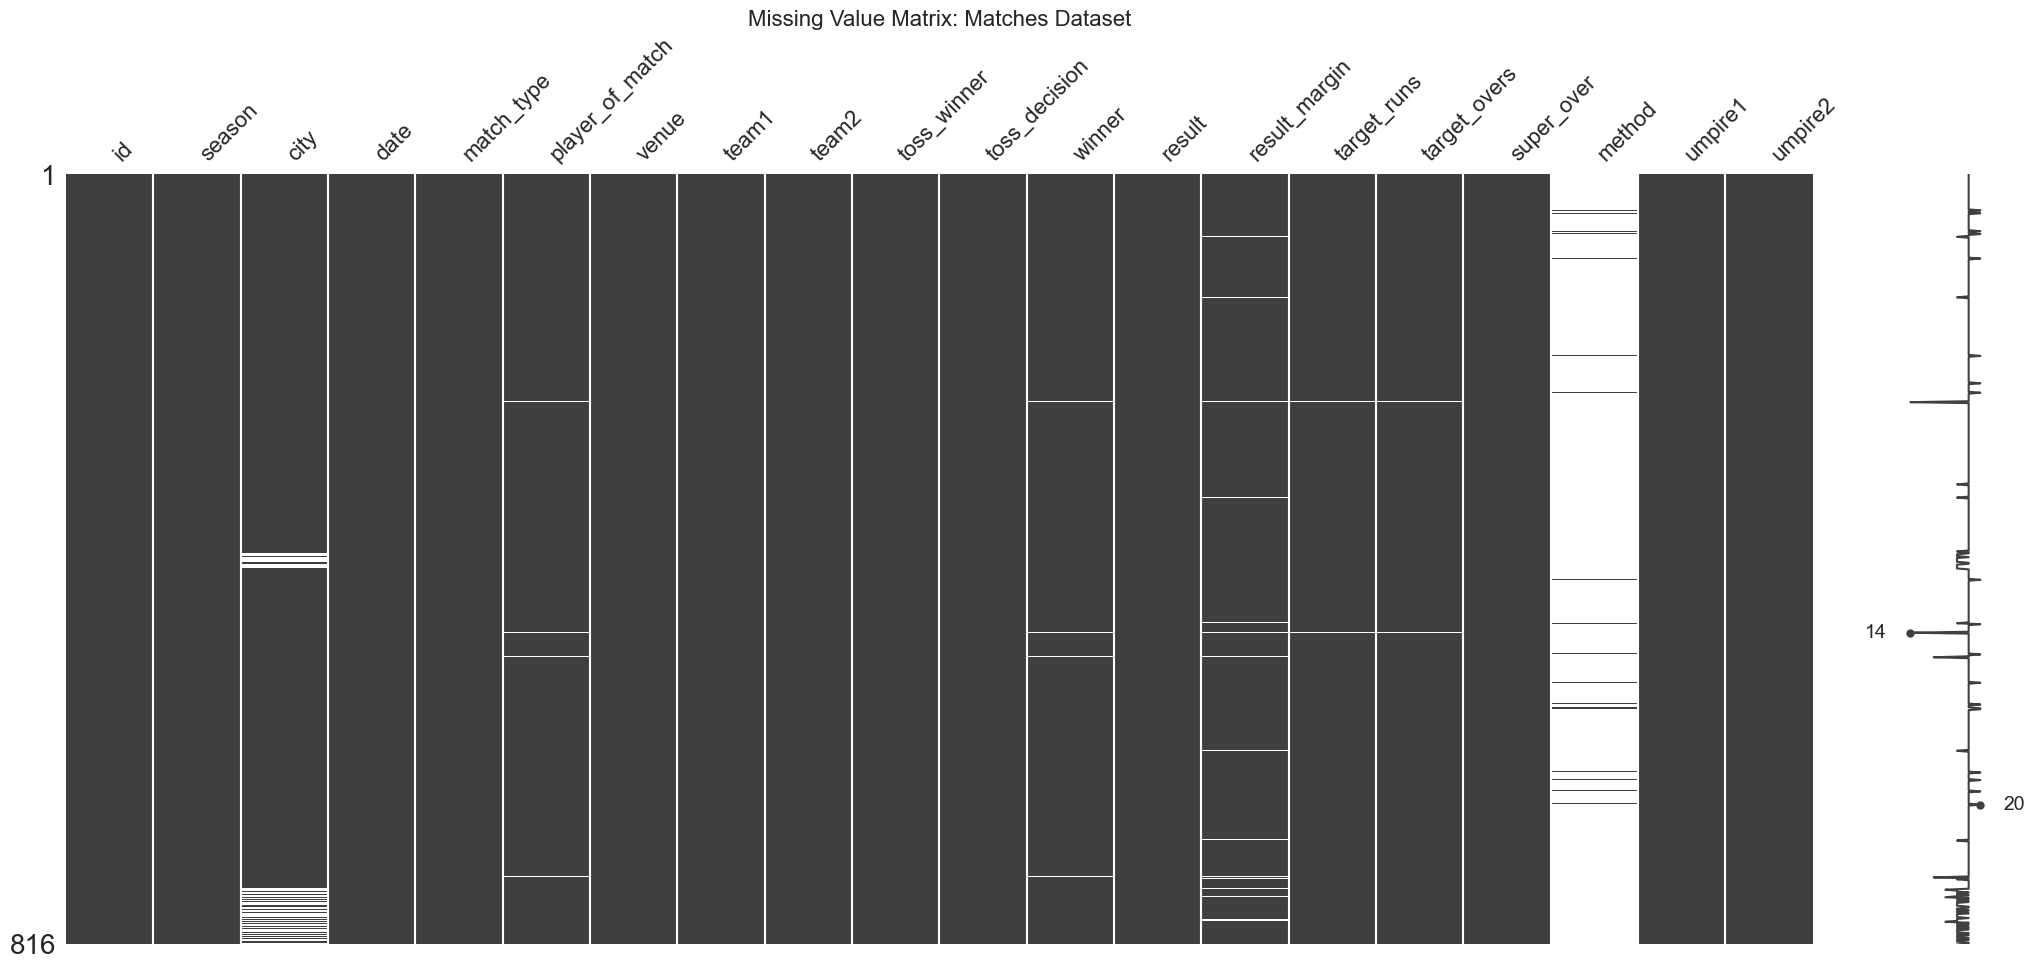

In [36]:
# Visualizing missing values
plt.figure(figsize=(10,4))
msno.matrix(match_df)
plt.title("Missing Value Matrix: Matches Dataset", fontsize=16)
plt.savefig(os.path.join(FIGURE_PATH, "01_missing_matrix_matches.png"))
plt.show()

In [37]:
# % Missing per column
match_missing = (match_df.isnull().sum() / len(match_df) * 100).sort_values(ascending=False)
ball_missing = (ball_df.isnull().sum() / len(ball_df) * 100).sort_values(ascending=False)

print("Top Missing Values (Matches) (%):")
print(match_missing[match_missing > 0])
print("\nTop Missing Values (Balls) (%):")
print(ball_missing[ball_missing > 0])

Top Missing Values (Matches) (%):
method             97.671569
city                6.250000
result_margin       2.083333
winner              0.490196
player_of_match     0.490196
target_overs        0.245098
target_runs         0.245098
dtype: float64

Top Missing Values (Balls) (%):
fielder             96.496692
dismissal_kind      95.082043
player_dismissed    95.082043
extras_type         94.707076
dtype: float64


### Strategic Decisions on Missing Data

1.  **`method` (97% missing)**: This refers to D/L method for rain-affected games. We will drop this column as it lacks sufficient density for modeling.
2.  **`city` (~1.5% missing)**: These usually occur when the venue is recorded but city is not (e.g., Dubai/Sharjah in early records). We can impute these mapping from the `venue` column.
3.  **`winner` / `result` (4 rows missing)**: These represent 'No Result' or abandoned matches. We will drop these rows as they provide no signal for win-prediction.
4.  **`player_dismissed` / `fielder` (Balls)**: High missing counts here are standard; they only populate when a wicket falls. We will treat `NaN` as 'No Wicket'.

## 1.3 Statistical Summary

We now analyze the central tendency and dispersion of our numerical features.

In [38]:
# Matches Statistical Profile
match_numeric = match_df.select_dtypes(include=[np.number])
desc = match_numeric.describe().T
desc['skew'] = match_numeric.skew()
desc['kurtosis'] = match_numeric.kurtosis()
desc

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
id,816.0,756349.553922,305894.254804,335982.0,501227.75,729298.0,1082626.25,1237181.0,0.210675,-1.489369
result_margin,799.0,17.321652,22.068427,1.0,6.00,8.0,19.50,146.0,2.692045,8.359213
target_runs,814.0,161.733415,32.225893,43.0,143.00,164.0,183.00,264.0,-0.479895,1.030381
target_overs,814.0,19.693120,1.807794,5.0,20.00,20.0,20.00,20.0,-6.273866,39.789225


### Statistical Interpretation
- **`result_margin`**: High standard deviation indicates significant variance in how easily games are won. Positive **skewness** tells us most games have small margins, with a long tail of "heavy victories".
- **`super_over`**: Extremely high kurtosis is expected as the occurrence is a binary outlier event in match history.

In [39]:
# Outlier Detection using IQR Method
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

outliers, lb, ub = detect_outliers_iqr(match_df.dropna(subset=['result_margin']), 'result_margin')
print(f"Result Margin Outliers (> {ub:.2f}): {len(outliers)}")

Result Margin Outliers (> 39.75): 94


## 1.4 Distribution Analysis

Visualizing the 'Shape' of cricket performance.

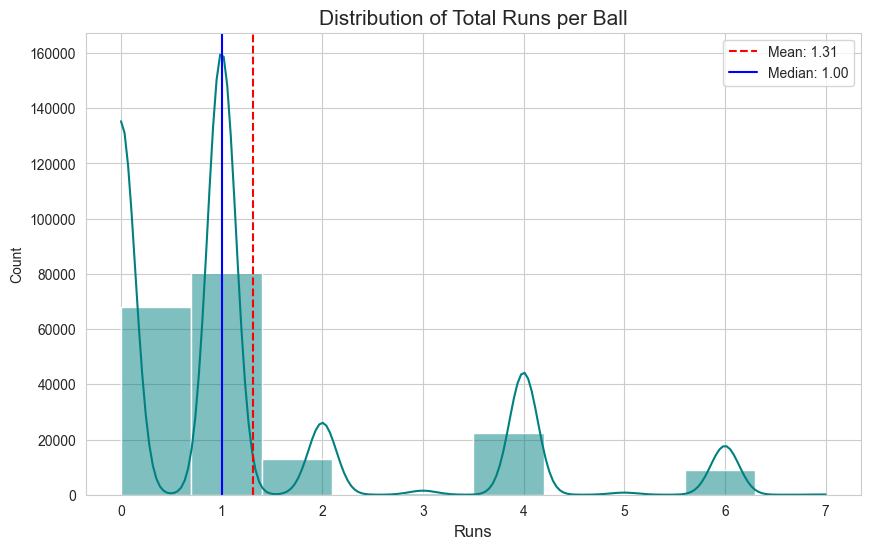

In [40]:
# Total Runs Distribution (Ball-by-Ball)
plt.figure(figsize=(10, 6))
sns.histplot(ball_df['total_runs'], kde=True, color='teal', bins=10)
plt.axvline(ball_df['total_runs'].mean(), color='red', linestyle='--', label=f'Mean: {ball_df["total_runs"].mean():.2f}')
plt.axvline(ball_df['total_runs'].median(), color='blue', linestyle='-', label=f'Median: {ball_df["total_runs"].median():.2f}')
plt.title("Distribution of Total Runs per Ball", fontsize=15)
plt.xlabel("Runs", fontsize=12)
plt.legend()
plt.savefig(os.path.join(FIGURE_PATH, "02_runs_distribution.png"))
plt.show()

### Insight
The distribution of `total_runs` is heavily **right-skewed**. The vast majority of deliveries result in 0 or 1 run (Median). The Mean is pulled higher by boundary outlier events (4s and 6s), indicating that cricket scoring is dominated by high-frequency low-scoring events and low-frequency high-impact events.